In [26]:
import numpy as np
import pandas as pd

# For statistical tests
from scipy import stats

# For visualization
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Show all columns
pd.set_option('display.max_columns', None)

# For text EDA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# For entropy computation
from pyitlib import discrete_random_variable as drv


from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")

In [27]:
# Initiate dataframe
df_train = pd.read_csv('train.csv', index_col=None)
df_test = pd.read_csv('test.csv', index_col=None)
df_valid = pd.read_csv('valid.csv', index_col=None)

In [28]:
import optuna
from sklearn import linear_model
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection

In [29]:
def get_confusion_matrix(actual, predicted, title):
    cf = confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

In [30]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_train_and_test_values(df_train, df_valid, df_test)

In [31]:
from collections import Counter
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_valid).items()))

[(0, 6580), (1, 5946)]
[(0, 2131), (1, 134)]
[(0, 2131), (1, 134)]


### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [11]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Step 2. Setup values for the hyperparameters:
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 150)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 60)
    rf_bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf_max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt'])
    
    classifier_obj = ensemble.RandomForestClassifier(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        bootstrap = rf_bootstrap,
        max_features=rf_max_features,
        random_state = 0
    )
    
    cl_model = classifier_obj.fit(X_train_resampled,y_train_resampled)

    # Step 3: Scoring method:
    predictions = cl_model.predict(X_valid)
    return metrics.recall_score(y_valid, predictions)

# Step 4: Running it
study_recall = optuna.create_study(direction="maximize")
study_recall.optimize(objective, n_trials=100)

[I 2022-11-13 15:12:29,779] A new study created in memory with name: no-name-69cef19b-5a43-47de-a4cf-c9443526c37b
[I 2022-11-13 15:12:38,349] Trial 0 finished with value: 0.5149253731343284 and parameters: {'n_estimators': 445, 'max_depth': 27, 'min_samples_split': 23, 'min_samples_leaf': 34, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5149253731343284.
[I 2022-11-13 15:12:41,607] Trial 1 finished with value: 0.6268656716417911 and parameters: {'n_estimators': 199, 'max_depth': 9, 'min_samples_split': 106, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6268656716417911.
[I 2022-11-13 15:12:57,804] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 891, 'max_depth': 20, 'min_samples_split': 75, 'min_samples_leaf': 26, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 0.6268656716417911.
[I 2022-11-13 15:13:01,066] Trial 3 finished with value: 0.6343283582089553 and par

[I 2022-11-13 15:14:12,604] Trial 29 finished with value: 0.7089552238805971 and parameters: {'n_estimators': 11, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 34, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8432835820895522.
[I 2022-11-13 15:14:14,740] Trial 30 finished with value: 0.746268656716418 and parameters: {'n_estimators': 174, 'max_depth': 4, 'min_samples_split': 46, 'min_samples_leaf': 15, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8432835820895522.
[I 2022-11-13 15:14:15,164] Trial 31 finished with value: 0.7014925373134329 and parameters: {'n_estimators': 61, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 19, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8432835820895522.
[I 2022-11-13 15:14:15,275] Trial 32 finished with value: 0.8134328358208955 and parameters: {'n_estimators': 15, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 25, 'boo

[I 2022-11-13 15:15:19,558] Trial 58 finished with value: 0.7611940298507462 and parameters: {'n_estimators': 42, 'max_depth': 4, 'min_samples_split': 36, 'min_samples_leaf': 51, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8432835820895522.
[I 2022-11-13 15:15:23,822] Trial 59 finished with value: 0.5149253731343284 and parameters: {'n_estimators': 311, 'max_depth': 16, 'min_samples_split': 23, 'min_samples_leaf': 17, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 20 with value: 0.8432835820895522.
[I 2022-11-13 15:15:24,129] Trial 60 finished with value: 0.7388059701492538 and parameters: {'n_estimators': 38, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 27, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8432835820895522.
[I 2022-11-13 15:15:24,783] Trial 61 finished with value: 0.7238805970149254 and parameters: {'n_estimators': 90, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 33, 'bo

[I 2022-11-13 15:16:06,231] Trial 87 finished with value: 0.6940298507462687 and parameters: {'n_estimators': 562, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 20, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 68 with value: 0.8507462686567164.
[I 2022-11-13 15:16:06,350] Trial 88 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 37, 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 68 with value: 0.8507462686567164.
[I 2022-11-13 15:16:11,185] Trial 89 finished with value: 0.3208955223880597 and parameters: {'n_estimators': 240, 'max_depth': 26, 'min_samples_split': 17, 'min_samples_leaf': 17, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 68 with value: 0.8507462686567164.
[I 2022-11-13 15:16:11,924] Trial 90 finished with value: 0.7089552238805971 and parameters: {'n_estimators': 99, 'max_depth': 4, 'min_samples_split': 90, 'min_samples_leaf': 30, 

In [12]:
trial_recall = study_recall.best_trial

print(f"Trial of Choice: ")
print(f"\tnumber: {trial_recall.number}")
print(f"\tparams: {trial_recall.params}")
print(f"\tvalues: {trial_recall.values}")

Trial of Choice: 
	number: 68
	params: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 29, 'bootstrap': True, 'max_features': 'sqrt'}
	values: [0.8507462686567164]


In [47]:
rf_test2 = RandomForestClassifier(random_state=0)
rf_test2.set_params(**trial_recall.params)
rf_test2.set_params(**best)
rf_test2.fit(X_train_resampled,y_train_resampled)
# make predictions for test data
predictions = rf_test2.predict(X_valid)

# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.085
Accuracy: 0.452
Recall: 0.851
F1: 0.155
Fbeta: 0.304
ROC AUC: 0.639
PR AUC: 0.081


<AxesSubplot:title={'center':'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

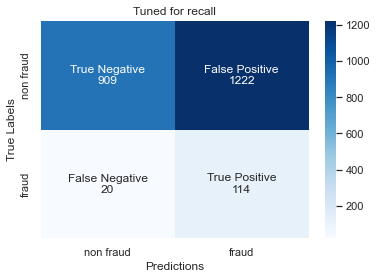

In [48]:
get_confusion_matrix(y_valid,predictions, "Tuned for recall")

#### Finding hyperparameter with the best f2 score

In [90]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Step 2. Setup values for the hyperparameters:
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 150)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 60)
    rf_bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf_max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt'])
    
    classifier_obj = ensemble.RandomForestClassifier(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        bootstrap = rf_bootstrap,
        max_features=rf_max_features,
        random_state = 0
    )
    
    cl_model = classifier_obj.fit(X_train_resampled,y_train_resampled)

    # Step 3: Scoring method:
    predictions = cl_model.predict(X_valid)
    recall = metrics.recall_score(y_valid, predictions)
    fbeta = metrics.fbeta_score(y_valid, predictions, beta = 2)
    return fbeta

# Step 4: Running it
study_fbeta = optuna.create_study(directions=["maximize"])
study_fbeta.optimize(objective, n_trials=50)

[I 2022-11-13 17:31:32,256] A new study created in memory with name: no-name-56ed7800-9019-482c-aa0d-6df6c44b5e3a
[I 2022-11-13 17:31:36,912] Trial 0 finished with value: 0.26830808080808083 and parameters: {'n_estimators': 924, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 41, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 0 with value: 0.26830808080808083.
[I 2022-11-13 17:31:38,133] Trial 1 finished with value: 0.257703081232493 and parameters: {'n_estimators': 210, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 59, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.26830808080808083.
[I 2022-11-13 17:31:38,935] Trial 2 finished with value: 0.2650602409638554 and parameters: {'n_estimators': 197, 'max_depth': 2, 'min_samples_split': 99, 'min_samples_leaf': 43, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.26830808080808083.
[I 2022-11-13 17:31:44,749] Trial 3 finished with value: 0.2585365853

[I 2022-11-13 17:34:51,976] Trial 29 finished with value: 0.3021523178807947 and parameters: {'n_estimators': 889, 'max_depth': 17, 'min_samples_split': 114, 'min_samples_leaf': 38, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.32280701754385965.
[I 2022-11-13 17:34:59,742] Trial 30 finished with value: 0.31655844155844154 and parameters: {'n_estimators': 771, 'max_depth': 24, 'min_samples_split': 113, 'min_samples_leaf': 18, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.32280701754385965.
[I 2022-11-13 17:35:07,119] Trial 31 finished with value: 0.3005686433793664 and parameters: {'n_estimators': 761, 'max_depth': 25, 'min_samples_split': 107, 'min_samples_leaf': 17, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.32280701754385965.
[I 2022-11-13 17:35:13,414] Trial 32 finished with value: 0.30377668308702793 and parameters: {'n_estimators': 637, 'max_depth': 18, 'min_samples_split': 123, 'min_sample

In [91]:
trial_fbeta = study_fbeta.best_trial

print(f"Trial of Choice: ")
print(f"\tnumber: {trial_fbeta.number}")
print(f"\tparams: {trial_fbeta.params}")
print(f"\tvalues: {trial_fbeta.values}")

Trial of Choice: 
	number: 40
	params: {'n_estimators': 254, 'max_depth': 12, 'min_samples_split': 120, 'min_samples_leaf': 24, 'bootstrap': True, 'max_features': 'sqrt'}
	values: [0.32623626373626374]


In [60]:
rf_test = RandomForestClassifier(random_state=0)
rf_test.set_params(**trial_fbeta.params)
rf_test.fit(X_train_resampled,y_train_resampled)

# make predictions for test data
predictions = rf_test.predict(X_valid)

# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.124
Accuracy: 0.732
Recall: 0.582
F1: 0.205
Fbeta: 0.335
ROC AUC: 0.662
PR AUC: 0.097


<AxesSubplot:title={'center':'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

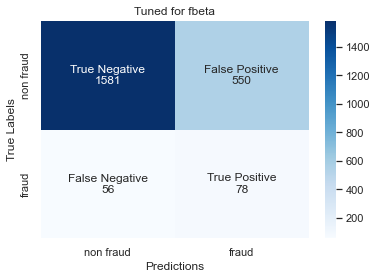

In [61]:
#Confusion Matrix
get_confusion_matrix(y_valid,predictions, "Tuned for fbeta")

### SHAP

In [99]:
import shap
# Fits the explainer
explainer = shap.Explainer(rf_test2.predict, X_train_resampled, seed=0)
shap_values = explainer(X_train_resampled[1:1000,:])

Permutation explainer: 1000it [00:35, 22.34it/s]                        


In [52]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [50]:
X_display = df_train.drop('FraudFound_P', axis=1)

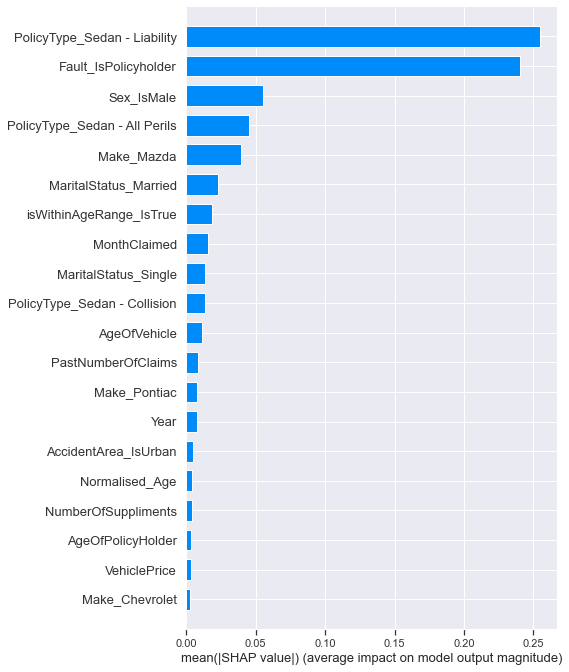

In [57]:
shap.summary_plot(shap_values, X_display, plot_type="bar", feature_names=features)

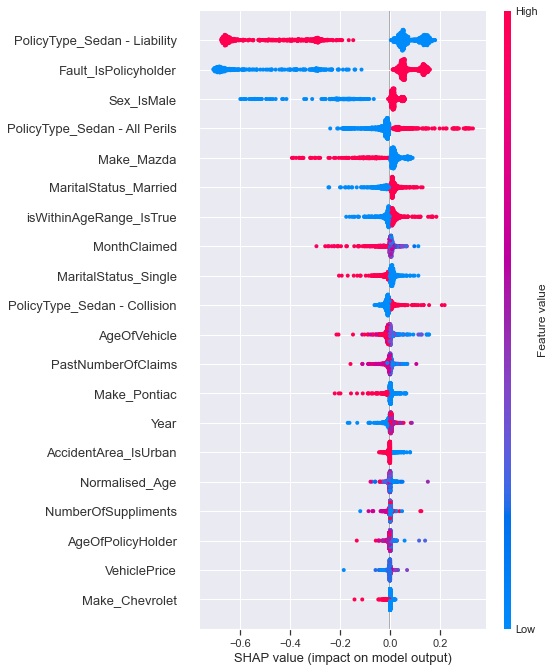

In [58]:
shap.summary_plot(shap_values, X_train_resampled[1:1000,:],features)